In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.feature_selection import mutual_info_regression
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
from scipy import linalg
import scipy.integrate as integrate
from scipy.special import gamma
import time

from sklearn.mixture import GaussianMixture as GMM
from sklearn.mixture._gaussian_mixture import _estimate_log_gaussian_prob, _compute_precision_cholesky, _estimate_gaussian_covariances_full
from sklearn.utils import check_random_state
from sklearn import cluster
from sklearn.model_selection import KFold

import pandas as pd
from astropy.stats import sigma_clip

In [4]:
class my_GMM(GMM):
    """
    Custom GMM class based on the sklearn GMM class.
    This allows to work with a GMM with fixed parameters, without fitting it.
    It also allows to estimate MI with a certain number of MC samples.
    The different initialisation types are dealt with separately.
    """
    def __init__(self,
                 n_components=1,
                 covariance_type="full",
                 tol=1e-5,
                 reg_covar=1e-6,
                 max_iter=100,
                 n_init=1,
                 init_params="random",
                 random_state=None,
                 warm_start=False,
                 verbose=0,
                 verbose_interval=10,
                 weights_init=None,
                 means_init=None,
                 precisions_init=None,
                 covariances_init=None
                 ):
        super(my_GMM, self).__init__(n_components=n_components,
                 covariance_type=covariance_type,
                 tol=tol,
                 reg_covar=reg_covar,
                 max_iter=max_iter,
                 n_init=n_init,
                 init_params=init_params,
                 random_state=random_state,
                 warm_start=warm_start,
                 verbose=verbose,
                 verbose_interval=verbose_interval,
                 weights_init=weights_init,
                 means_init=means_init,
                 precisions_init=precisions_init,
                )

        self.means_ = means_init
        self.covariances_ = covariances_init
        self.covariances_init = covariances_init
        self.weights_ = weights_init
        #self.random_state = random_state
        #self.covariance_type = covariance_type
        #self.precisions_cholesky_ = _compute_precision_cholesky(
        #        self.covariances_, self.covariance_type
        #    )


    def score_samples(self, X):
        """Compute the log-likelihood of each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)

        return logsumexp(self._estimate_weighted_log_prob(X), axis=1)

    def predict(self, X):
        """Predict the labels for the data samples in X using trained model.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        return self._estimate_weighted_log_prob(X).argmax(axis=1)

    def predict_proba(self, X):
        """Evaluate the components' density for each sample.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        Returns
        -------
        resp : array, shape (n_samples, n_components)
            Density of each Gaussian component for each sample in X.
        """
        # copied here to remove the fitting check
        #check_is_fitted(self)
        #X = self._validate_data(X, reset=False)
        _, log_resp = self._estimate_log_prob_resp(X)
        return np.exp(log_resp)

    def sample(self, n_samples=1):
        """Generate random samples from the fitted Gaussian distribution.
        Parameters
        ----------
        n_samples : int, default=1
            Number of samples to generate.
        Returns
        -------
        X : array, shape (n_samples, n_features)
            Randomly generated sample.
        y : array, shape (nsamples,)
            Component labels.
        """
        # copied here to remove the fitting check
        # check_is_fitted(self)

        if n_samples < 1:
            raise ValueError(
                "Invalid value for 'n_samples': %d . The sampling requires at "
                "least one sample." % (self.n_components)
            )

        _, n_features = self.means_.shape
        rng = check_random_state(self.random_state)
        n_samples_comp = rng.multinomial(n_samples, self.weights_)

        if self.covariance_type == "full":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, covariance, int(sample))
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )
        elif self.covariance_type == "tied":
            X = np.vstack(
                [
                    rng.multivariate_normal(mean, self.covariances_, int(sample))
                    for (mean, sample) in zip(self.means_, n_samples_comp)
                ]
            )
        else:
            X = np.vstack(
                [
                    mean + rng.randn(sample, n_features) * np.sqrt(covariance)
                    for (mean, covariance, sample) in zip(
                        self.means_, self.covariances_, n_samples_comp
                    )
                ]
            )

        y = np.concatenate(
            [np.full(sample, j, dtype=int) for j, sample in enumerate(n_samples_comp)]
        )

        return (X, y)

    def score_samples_marginal(self, X, index=0):
        """Compute the log-likelihood of each sample for the marginal model, indexed by either 0 (x) or 1 (y).
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        index: integer
            Either 0 (marginal x) or 1 (marginal y).
        Returns
        -------
        log_prob : array, shape (n_samples,)
            Log-likelihood of each sample in `X` under the current model.
        """

        oned_cholesky = np.sqrt(1/self.covariances_[:, index, index]).reshape(-1, 1, 1)
        marginal_logprob = _estimate_log_gaussian_prob(
            X, self.means_[:, index].reshape(-1, 1), oned_cholesky, self.covariance_type
        )

        return logsumexp(np.log(self.weights_) + marginal_logprob, axis=1)


    def estimate_MI_MC(self, MC_samples=100):
        """
        Compute the mutual information (MI) associated with a particular GMM model, using MC integration
        Parameters
        ----------
        MC_samples : integer
            Number of Monte Carlo samples to perform numerical integration of the MI integral.
        Returns
        ----------
        MI : integer
            The value of mutual information.
        -------
        """
        # sample MC samples
        points, clusters = self.sample(MC_samples)
        
        # we first evaluate the log-likelihood for the joint probability
        joint = self.score_samples(points)

        # we then evaluate the marginals; index=0 corresponds to x, index=y corresponds to y
        marginal_x = self.score_samples_marginal(points[:, :1], index=0)
        marginal_y = self.score_samples_marginal(points[:, 1:], index=1)

        MI = np.mean(joint - marginal_x - marginal_y)
        return MI
    
    def fit_predict(self, X, y=None):
        """Estimate model parameters using X and predict the labels for X.
        The method fits the model n_init times and sets the parameters with
        which the model has the largest likelihood or lower bound. Within each
        trial, the method iterates between E-step and M-step for `max_iter`
        times until the change of likelihood or lower bound is less than
        `tol`, otherwise, a :class:`~sklearn.exceptions.ConvergenceWarning` is
        raised. After fitting, it predicts the most probable label for the
        input data points.
        .. versionadded:: 0.20
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            List of n_features-dimensional data points. Each row
            corresponds to a single data point.
        y : Ignored
            Not used, present for API consistency by convention.
        Returns
        -------
        labels : array, shape (n_samples,)
            Component labels.
        """
        X = self._validate_data(X, dtype=[np.float64, np.float32], ensure_min_samples=2)
        if X.shape[0] < self.n_components:
            raise ValueError(
                "Expected n_samples >= n_components "
                f"but got n_components = {self.n_components}, "
                f"n_samples = {X.shape[0]}"
            )
        self._check_initial_parameters(X)

        # if we enable warm_start, we will have a unique initialisation
        do_init = not (self.warm_start and hasattr(self, "converged_"))
        n_init = self.n_init if do_init else 1

        max_lower_bound = -np.inf
        self.converged_ = False

        random_state = check_random_state(self.random_state)

        n_samples, _ = X.shape
        for init in range(n_init):
            self._print_verbose_msg_init_beg(init)

            if do_init:
                self._initialize_parameters(X, random_state)

            lower_bound = -np.inf if do_init else self.lower_bound_

            for n_iter in range(1, self.max_iter + 1):
                #if n_iter==179:
                #    try:
                #        #print(n_iter)
                #        print(np.linalg.eig(self.covariances_[2]))
                #        #print(self.means_[2])
                #        #ind = np.argsort(log_resp[:, 2])[-5:]
                #        #print(X[ind])
                #        #print(log_resp[np.argmax(log_resp[:, 2])])
                #        #plt.hist(log_resp[:, 4])
                #    except:
                #        pass

                prev_lower_bound = lower_bound

                log_prob_norm, log_resp = self._e_step(X)
                self._m_step(X, log_resp)
                lower_bound = self._compute_lower_bound(log_resp, log_prob_norm)

                change = lower_bound - prev_lower_bound
                self._print_verbose_msg_iter_end(n_iter, change)

                if abs(change) < self.tol:
                    self.converged_ = True
                    break

            self._print_verbose_msg_init_end(lower_bound)

            if lower_bound > max_lower_bound or max_lower_bound == -np.inf:
                max_lower_bound = lower_bound
                best_params = self._get_parameters()
                best_n_iter = n_iter

        if not self.converged_:
            warnings.warn(
                "Initialization %d did not converge. "
                "Try different init parameters, "
                "or increase max_iter, tol "
                "or check for degenerate data." % (init + 1),
                ConvergenceWarning,
            )

        self._set_parameters(best_params)
        self.n_iter_ = best_n_iter
        self.lower_bound_ = max_lower_bound

        # Always do a final e-step to guarantee that the labels returned by
        # fit_predict(X) are always consistent with fit(X).predict(X)
        # for any value of max_iter and tol (and any random_state).
        _, log_resp = self._e_step(X)

        return log_resp.argmax(axis=1)
        


In [5]:
# now we also focus on initialising the GMM parameters
# we provide four different initialisation types, which return weights, means and covs
# these will go as input into the GMM class, so that we can ignore whatever happens there

  
def initialize_parameters(X, random_state, n_components=1, s=None, reg_covar=1e-6, init_type='random'):
    """Initialize the model parameters.
    Parameters
    ----------
    X : array-like of shape  (n_samples, n_features)
    random_state : RandomState
        A random number generator instance that controls the random seed used for the method chosen to initialize the parameters.
    n_components: int
        Number of components of the GMM to fit.
    s : float
        If set, sets component variances in the 'random' and 'minmax' cases. 
        If s is not given, it will be set such that the volume of all components
        completely fills the space covered by data.
    init_type : {'random', 'minmax', 'kmeans', 'random_sklearn', 'kmeans_sklearn'}, default='random'
        The method used to initialize the weights, the means and the
        precisions.
        Must be one of:
            'random': weights are set uniformly, covariances are proprtional to identity (with prefactor s^2). 
            For each mean, a data sample is selected at random, and a multivariant Gaussian with variance s^2 offset is added.
            'minmax': same as above, but means are distributed randomly over the range that is covered by data.
            'kmeans': k-means clustering run as in Algorithm 1 from Bloemer & Bujna (arXiv:1312.5946), as implemented by Melchior & Goulding (arXiv:1611.05806)
             WARNING: The result of this call are not deterministic even if rng is set because scipy.cluster.vq.kmeans2 uses its own initialization. 
             TO DO: require scipy > 1.7, and include "seed=random_state" in the kmeans call
            'kmeans_sklearn' : responsibilities are initialized using kmeans.
            'random_sklearn' : responsibilities are initialized randomly.
    reg_covar : float
        The regularization added to the diagonal of the covariance matrices.
    Returns
    ----------
    weights : array, shape (n_components, 1)
        The initial weights of the GMM model.
    means : array, shape (n_components, n_features)
        The initial means of the GMM model.        
    covariances : array, shape (n_components, n_features, n_features)
        The initial covariance matrices of the GMM model.        
    """
    n_samples, n_dim = X.shape

    random_state = check_random_state(random_state)
    if s is None and (init_type=='random' or init_type=='minmax'):
        min_pos = X.min(axis=0)
        max_pos = X.max(axis=0)
        vol_data = np.prod(max_pos-min_pos)
        s = (vol_data / n_components * gamma(n_dim*0.5 + 1))**(1/n_dim) / np.sqrt(np.pi)
        print(f"Scale s set to s={s:.2f}...")

    if init_type == "random":

        weights = np.repeat(1/n_components, n_components)
        # initialize components around data points with uncertainty s
        refs = random_state.randint(0, n_samples, size=n_components)

        means = X[refs] + random_state.multivariate_normal(np.zeros(n_dim), s**2 * np.eye(n_dim), size=n_components)
        
        covariances = np.repeat(s**2 * np.eye(n_dim)[np.newaxis, :, :], n_components, axis=0)

    elif init_type == "minmax":

        weights = np.repeat(1/n_components, n_components)

        min_pos = X.min(axis=0)
        max_pos = X.max(axis=0)
        means = min_pos + (max_pos-min_pos)*random_state.rand(n_components, n_dim)
        
        covariances = np.repeat(s**2 * np.eye(n_dim)[np.newaxis, :, :], n_components, axis=0)

    elif init_type == 'kmeans':
        from scipy.cluster.vq import kmeans2
        center, label = kmeans2(X, n_components)
        weights = np.zeros(n_components)
        means = np.zeros((n_components, n_dim))
        covariances = np.zeros((n_components, n_dim, n_dim))

        for k in range(n_components):
            mask = (label == k)
            weights[k] = mask.sum() / len(X)
            means[k,:] = X[mask].mean(axis=0)
            d_m = X[mask] - means[k,:] 
            # funny way of saying: for each point i, do the outer product
            # of d_m with its transpose and sum over i
            covariances[k,:,:] = (d_m[:, :, None] * d_m[:, None, :]).sum(axis=0) / len(X)

    elif init_type == "random_sklearn":
        resp = random_state.rand(n_samples, n_components)
        resp /= resp.sum(axis=1)[:, np.newaxis]
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        
        weights = nk/n_samples
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covariances = _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)

    elif init_type == "kmeans_sklearn":
        resp = np.zeros((n_samples, n_components))
        label = (
            cluster.KMeans(
                n_clusters=n_components, n_init=1, random_state=random_state
            )
            .fit(X)
            .labels_
        )
        resp[np.arange(n_samples), label] = 1
        nk = resp.sum(axis=0) + 10 * np.finfo(resp.dtype).eps
        
        weights = nk/n_samples
        means = np.dot(resp.T, X) / nk[:, np.newaxis]
        covariances = _estimate_gaussian_covariances_full(resp, X, nk, means, reg_covar)

    else:
        # TO DO: raise error instead of just priting it
        print("Error: initalisation type not specified or not known; it should be one of 'random', 'minmax', 'kmeans', 'random_sklearn', 'kmeans_sklearn'")
        
    precisions = np.empty_like(covariances)
    for i in range(n_components):
        precisions[i] = np.linalg.inv(covariances[i])
        
    return weights, means, covariances, precisions


In [6]:
def MI_procedure_diffconvergence(X, n_components=1, n_folds=5, n_inits=5, init_type='random', reg_covar=1e-6, tol=1e-6):
    """
    Docstring TO DO
    """
    initial_time = time.time()
    # this will be used to store mean validation log-likelihood 
    val_scores_seeds = np.zeros(n_inits)
    train_scores_seeds = np.zeros(n_inits)

    # prepare the folds; note the splitting will be the same for all initialisations
    # the random seed is fixed here, but results should be independent of the exact split
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    # fix the random seed first
    for r in range(n_inits):

        w_init, m_init, c_init, p_init = initialize_parameters(X, r, n_components=n_components, init_type=init_type)
        validation_scores = []
        training_scores = []
        
        for train_indices, valid_indices in kf.split(X):
            X_training = X[train_indices]
            X_validation = X[valid_indices]
            
            fitted_gmm = my_GMM(n_components=n_components, reg_covar=reg_covar, 
                            tol=tol, max_iter=10000, 
                            random_state=r, weights_init=w_init, 
                            means_init=m_init, precisions_init=p_init).fit(X_training)

            # we take the mean logL per sample, since folds might have slightly different sizes
            val_score = fitted_gmm.score_samples(X_validation).mean()
            train_score = fitted_gmm.score_samples(X_training).mean()

            #print(val_score)
            validation_scores.append(np.copy(val_score))
            training_scores.append(np.copy(train_score))


        # take mean of current seed's val scores
        val_scores_seeds[r] = np.mean(validation_scores)
        train_scores_seeds[r] = np.mean(training_scores)

        #print()
        
    # select seed with highest val score
    best_seed = np.argmax(val_scores_seeds)
    best_val_score = np.max(val_scores_seeds)
    best_train_score = np.max(train_scores_seeds)
    
    return best_seed, best_val_score, best_train_score

### Let's look at MI 

In [7]:
#codes_file = np.load('encoded_harps_unique_128d_e182_i1500000.npy')
#codes_file_new = np.load('./astro-machines/encoded/encoded_harps_unique_128d_e182_i1500000.npy')

#old = pd.read_csv('harps_metadata_and_labels.csv')
#new =  pd.read_csv('./astro-machines/lists/harps_metadata_and_labels.csv')

In [18]:
codes_file = 'encoded_harps_unique_128d_e182_i1500000.npy'  # checked these are identical between this repo and the one shared by Nima
codes = pd.DataFrame(np.load(codes_file))

labels = pd.read_csv('harps_metadata_and_labels.csv')

#--- If looking at the 'unique' subset, drop unnecessary rows
if "unique" in codes_file:
    labels.dropna(subset=['unique_subset'],inplace=True)

#--- and reindex the codes dataframe accordingly
codes.loc[:,'dp_id'] = labels['dp_id'].values
labels = labels.set_index('dp_id')
codes = codes.set_index('dp_id')

In [19]:
labels

,target_name,target_name_fixed,fixed_name_count,median,unique_subset,spec_type,spec_type_no,s_ra,s_dec,Teff,...,logg,s_logg,[M/H],e_[M/H],Mass,s_Mass,radvel,airmass,snr,vsini
dp_id,,,,,,,,,,,,,,,,,,,,,
ADP.2014-09-16T11:03:31.127,HIP31292,HIP31292,19,783.440247,Y,M3V,6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6635,23.65,NaN
ADP.2014-09-16T11:03:31.413,HD139879,HD139879,20,510.975769,Y,G3V,4.0,235.229570,-9.00081,6248.9,...,4.3752,0.0751,0.3,0.06,1.21,0.168,-8.803,1.2535,22.10,NaN
ADP.2014-09-16T11:03:31.673,V4376_Sgr,V4376SGR,1,8315.300781,Y,F7V,3.0,269.815120,-19.54296,5261.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1235,95.15,NaN
ADP.2014-09-16T11:03:31.947,AO_For,AOFOR,1,10506.125977,Y,G6/8IV,4.0,40.767110,-31.06864,5229.0,...,NaN,NaN,NaN,NaN,NaN,NaN,-22.460,1.0005,109.80,NaN
ADP.2014-09-16T11:03:32.443,BD-100216,BD100216,4,570.137878,Y,K4/5V,5.0,15.491210,-9.88747,4215.0,...,4.5835,0.1086,NaN,NaN,0.66,0.082,-0.785,1.2515,20.90,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ADP.2018-07-26T01:02:10.221,Wcen,WCEN,6,17.998701,Y,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1635,1.75,NaN
ADP.2018-07-26T01:02:10.227,WASP-15b,WASP15B,2,916.055664,Y,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.4100,31.65,NaN
ADP.2018-08-30T01:01:14.775,C6_3289,C63289,24,1592.004883,Y,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.6455,43.45,NaN


In [9]:
from sklearn.feature_selection import mutual_info_regression
significant_dimensions = [ 11,  19,  58,  85,  99, 124]
stellar_params = ['radvel','Teff','Mass','[M/H]','airmass','snr','vsini']
MIs = np.zeros([len(stellar_params), \
                    len(significant_dimensions)])
codes_sig = codes.iloc[:, significant_dimensions]
                
for li,stellar_param in enumerate(stellar_params):        
    label = labels.loc[:,stellar_param].values
    
    ind_mask = ~np.isnan(label)
    label_ = sigma_clip(label,sigma=5,masked=True)

    ind_mask = ind_mask & (~label_.mask)
    label_ = label_.data[ind_mask]      
    for i in range(0,codes_sig.shape[1]):                          
        codes_ = codes_sig.iloc[:,i].values
        codes_ = codes_[ind_mask]
        
        MIs[li,i] = mutual_info_regression(codes_.reshape(-1, 1),label_)

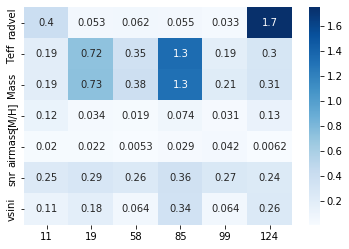

In [10]:
import seaborn as sns

plt.figure()
ax = sns.heatmap(MIs, annot=True, cmap='Blues')
ax.yaxis.set_ticklabels(stellar_params)
ax.xaxis.set_ticklabels(significant_dimensions)
plt.gcf().set_facecolor('white')

### Now use our approach

In [29]:
n_inits = 5
n_folds = 3
init_type = 'random_sklearn'
n_bootstrap = 100
MC_samples = 1e5
tol = 1e-5
reg_covar = 1e-13
components_range = 200
        
MI_all = np.zeros((len(stellar_params), 128, n_bootstrap))

for li,stellar_param in enumerate(stellar_params):
    if li == 0:
        continue
    label = labels.loc[:,stellar_param].values
    
    ind_mask = ~np.isnan(label)
    label_ = sigma_clip(label,sigma=5,masked=True)

    ind_mask = ind_mask & (~label_.mask)
    samples1 = label_.data[ind_mask]    

    for latbin2 in range(128):
        codes_ = codes.iloc[:,latbin2].values
        samples2 = codes_[ind_mask]

        X = np.stack((samples1, samples2), axis=0).T

        # now we do this for many components, from 1 to 15

        all_MI_estimates = np.zeros((components_range, n_bootstrap))

        best_val = -np.inf

        initial_time = time.time()
        for n_components in range(1, components_range+1):
            current_seed, current_val, _ = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                               init_type=init_type, n_inits=n_inits, tol=tol, reg_covar=reg_covar)

            # check if convergence has been reached based on val score
            if current_val > best_val:
                best_val = current_val
                best_seed = current_seed
                print(n_components, best_val)
            else:
                # if val score has not increased, then we should stop and calculate MI with the previous parameters
                best_components = n_components-1
                print(f'Convergence reached at {best_components} components') 
                w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=best_components, init_type=init_type)
                MI_estimates = np.zeros(n_bootstrap)

                # bootstrap available samples
                for i in range(n_bootstrap):
                    # we use i to change the seed so that the results will be fully reproducible
                    rng = np.random.default_rng(i)
                    X_bs = rng.choice(X, X.shape[0])
                    gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                                tol=tol, max_iter=10000, 
                                random_state=best_seed, weights_init=w_init, 
                                means_init=m_init, precisions_init=p_init).fit(X_bs)

                    # in case of "warm start", uncomment next line
                    #w_init, m_init, c_init, p_init = gmm.weights_, gmm.means_, gmm.covariances_, gmm.precisions_

                    current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples)
                    MI_estimates[i] = current_MI_estimate
                break

        print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
        print()
        MI_all[li, latbin2] = MI_estimates
        print(li, latbin2, np.mean(MI_estimates), np.std(MI_estimates))
        print()

1 -5.5518999213321365
2 -5.257307573087286
3 -5.195330591913328
4 -5.154772866336507
5 -5.132515013779365
6 -5.124617682695536
7 -5.108073058173004
8 -5.1073955547710606
9 -5.102421179454417
10 -5.099682920567702
11 -5.0994756316860315
12 -5.096491951828118
Convergence reached at 12 components
Total time to run the procedure: 384.88 s

1 0 0.1660523859883254 0.009611029880343005

1 -5.322060539492273
2 -5.0689505578239356
3 -5.009730557182614
4 -4.963130328354359
5 -4.953556782116135
6 -4.937378227507119
7 -4.907830564046381
8 -4.901235661608307
9 -4.899126603460527
10 -4.88942660199616
11 -4.887207651791481
12 -4.886527600264523
13 -4.885248325255817
14 -4.885071331148812
Convergence reached at 14 components
Total time to run the procedure: 592.96 s

1 1 0.15624630111160193 0.008508683401743407

1 -5.089431119819935
2 -4.846793672512711
3 -4.799632154552277
4 -4.769231116557234
5 -4.764476880984859
6 -4.754431286279244
7 -4.741356721897234
8 -4.735706331302149
9 -4.734387084176715
Con

8 -5.0948221607218
9 -5.0864381621982595
10 -5.0836057642571975
Convergence reached at 10 components
Total time to run the procedure: 307.18 s

1 25 0.1594289729047616 0.010478121131503494

1 -5.697115019273707
2 -5.44698739660859
3 -5.32348335710823
4 -5.301631596884758
5 -5.271578466735201
6 -5.257300494185819
7 -5.2507870188290235
8 -5.244937942871037
9 -5.242246405592232
10 -5.238086750867405
11 -5.231004582758776
12 -5.229744857391242
Convergence reached at 12 components
Total time to run the procedure: 420.74 s

1 26 0.2377759714292438 0.011849598459749281

1 -5.486582468266737
2 -5.1721637432400325
3 -5.115442006506208
4 -5.069985693193915
5 -5.051213429614484
6 -5.045829499459672
7 -5.039625503244399
8 -5.036577575771587
9 -5.030333083963246
10 -5.02580851585359
11 -5.022335362658354
Convergence reached at 11 components
Total time to run the procedure: 386.07 s

1 27 0.33182632310680055 0.01149748736636228

1 -5.282334827782411
2 -5.064371048640688
3 -4.975524173637754
4 -4.956

6 -5.077613685543103
7 -5.063256819603183
8 -5.056209724951021
9 -5.053789776564503
10 -5.0472908278321915
Convergence reached at 10 components
Total time to run the procedure: 290.00 s

1 50 0.2634894013845967 0.010426882040404178

1 -5.1690882621782945
2 -4.949599329000255
3 -4.9172852994540905
4 -4.905801631219979
5 -4.886662174612138
6 -4.878387309401297
7 -4.859239756639471
8 -4.857781612444413
9 -4.844745266302653
Convergence reached at 9 components
Total time to run the procedure: 287.86 s

1 51 0.1043054056754743 0.009203837387469148

1 -5.617984013879067
2 -5.346615029844194
3 -5.29143105375062
4 -5.274137668274822
5 -5.250789418968989
6 -5.244136131144507
7 -5.225470446771229
8 -5.2231293804138605
9 -5.221896348762164
10 -5.2178926432621076
11 -5.215028620391796
Convergence reached at 11 components
Total time to run the procedure: 333.96 s

1 52 0.22154717811056351 0.010330853199193716

1 -5.459476179897545
2 -5.212700933782227
3 -5.163345704522997
4 -5.141929306048674
5 -5.1

8 -5.073711035856132
9 -5.067651585298829
Convergence reached at 9 components
Total time to run the procedure: 208.61 s

1 75 0.2344365571078295 0.01125839333202546

1 -5.6475389862354
2 -5.354827475894072
3 -5.243184310934503
4 -5.225196849638963
5 -5.201291921556194
6 -5.1820390191984345
7 -5.1681533512070414
8 -5.149217942890827
9 -5.143428569535808
10 -5.138504584789094
11 -5.135784274790777
12 -5.132739676474627
13 -5.126813390281325
14 -5.117208995479566
Convergence reached at 14 components
Total time to run the procedure: 512.37 s

1 76 0.3341788974040047 0.012096557078725801

1 -5.3466272819976295
2 -5.0965516643180235
3 -5.069250813164708
4 -5.0298589336814965
5 -4.987640930713067
6 -4.970207303166532
7 -4.967843822213371
8 -4.946628104965371
Convergence reached at 8 components
Total time to run the procedure: 194.52 s

1 77 0.10301313665040832 0.008357665864002543

1 -5.426489875644532
2 -5.153992155092998
3 -5.1287258915791805
4 -5.106388935308121
5 -5.087092038910446
6 -5.0

5 -4.657883257659183
6 -4.635596121535084
7 -4.629322939531005
8 -4.624296344731316
9 -4.611477585195763
Convergence reached at 9 components
Total time to run the procedure: 206.55 s

1 100 0.2976623021000055 0.012025570067932898

1 -5.502697815295886
2 -5.198919823154481
3 -5.119637743641797
4 -5.08552589827518
5 -5.066862784863922
6 -5.054945436970802
7 -5.040072554186338
8 -5.039021359036295
9 -5.035978600382865
10 -5.034009484296782
11 -5.0333762747297
12 -5.032283644007749
Convergence reached at 12 components
Total time to run the procedure: 461.46 s

1 101 0.23744348568920468 0.00928216252414214

1 -5.500037615380855
2 -5.280645722450996
3 -5.225387018671693
4 -5.199592719572197
5 -5.188351664765326
6 -5.178970858497823
7 -5.168666449739429
8 -5.1631697216162395
9 -5.154762128878217
10 -5.152821925238431
11 -5.149840876954991
12 -5.149424242604527
Convergence reached at 12 components
Total time to run the procedure: 441.99 s

1 102 0.20166923508148343 0.010770988047603583

1 -5.5

8 -4.805794047127081
9 -4.793255304816805
10 -4.788795819136809
11 -4.787761546845162
12 -4.779876034750424
Convergence reached at 12 components
Total time to run the procedure: 499.94 s

1 125 0.12197745340715788 0.008859861212115535

1 -5.596624384300443
2 -5.317561703627329
3 -5.161749798711681
4 -5.142121139780122
5 -5.108780340888367
6 -5.094459741713126
7 -5.070755099129414
8 -5.062491027233889
9 -5.0571320517056835
Convergence reached at 9 components
Total time to run the procedure: 204.33 s

1 126 0.31731573006287334 0.011977998098909601

1 -5.283317773065918
2 -5.068268544188771
3 -5.0310911441109765
4 -5.0179904621181235
5 -4.993749680973164
6 -4.983958351476461
7 -4.967992851319212
8 -4.95909146015317
9 -4.95377105678275
10 -4.9467985341449365
11 -4.945032650195556
12 -4.943951151355738
13 -4.943806240961498
14 -4.943652272332581
15 -4.942993153510472
Convergence reached at 15 components


Total time to run the procedure: 753.72 s

1 127 0.12454152992608775 0.008191338960577981

1 2.520901841256569
2 2.8222630985907355
3 2.898247537658243
4 2.9574070448665886
5 2.9853569430280835
6 3.0035054712677263
7 3.0061952712773015
8 3.009863829024806
9 3.011170288181948
10 3.013167661083923
11 3.0135151025868563
12 3.0169733033494412
13 3.020761046864372
14 3.0265998531905645
Convergence reached at 14 components
Total time to run the procedure: 439.35 s

2 0 0.21545036394486192 0.01108717913522946

1 2.779370543114035
2 3.072632087045433
3 3.2159475354550318
4 3.2347049230548044
5 3.254234007878999
6 3.2812776536114967
7 3.29018719471344
8 3.295669394629392
9 3.296795001755592
10 3.3004103302445276
Convergence reached at 10 components
Total time to run the procedure: 271.64 s

2 1 0.16274478405580492 0.010948970001071973

1 3.0094492109162356
2 3.262698194676261
3 3.3058490889140675
4 3.333205976119237
5 3.3544119325762263
Convergence reached at 5 components
Total time to run the 

2 2.70307284708962
3 2.8250373877738473
4 2.8619373202161356
5 2.869342672244238
6 2.8833813674635693
7 2.8975878499501557
8 2.9108350415311492
9 2.9153068357603473
10 2.9216527292465826
11 2.93245275921834
Convergence reached at 11 components
Total time to run the procedure: 254.34 s

2 26 0.2804498554960532 0.01381854855216966

1 2.6432719365155926
2 2.9689449212141343
3 3.0254853267361628
4 3.050797618652594
5 3.072478673136929
6 3.0813732415466357
7 3.089291218953306
8 3.0899786202411277
Convergence reached at 8 components
Total time to run the procedure: 148.44 s

2 27 0.30357704364250515 0.011902532514455519

1 2.813131369464178
2 3.089187573848976
3 3.188565210378249
4 3.211580725145282
5 3.241487631349236
6 3.253296424435643
7 3.2548545039981236
Convergence reached at 7 components
Total time to run the procedure: 114.98 s

2 28 0.14431869916196796 0.009713948490994566

1 2.9842626600419297
2 3.1886162720306497
3 3.2873456161763195
4 3.315514582593927
5 3.3364091230261494
6 3.34

2 2.9217064292015156
3 2.9826180591886153
4 3.052982001866249
5 3.072651684365818
6 3.0925645124315317
7 3.0978844607492406
8 3.107037121249989
9 3.111094854904349
10 3.1127633780635544
Convergence reached at 10 components
Total time to run the procedure: 248.46 s

2 53 0.13522601687566815 0.009690233301036879

1 2.7280355656210715
2 3.078292272261496
3 3.1289338775375697
4 3.1605959278986226
5 3.1753633225845856
6 3.178460309715383
7 3.1784799489313236
8 3.1844101530785807
Convergence reached at 8 components
Total time to run the procedure: 147.82 s

2 54 0.24521337786338399 0.011660787899724015

1 2.4533005012595166
2 2.6916573914036603
3 2.7473201330463417
4 2.7955786748154208
5 2.8057471404500625
6 2.8157453218167015
7 2.8309481323870123
8 2.8349985528265074
9 2.840349553463812
Convergence reached at 9 components
Total time to run the procedure: 196.61 s

2 55 0.09150281903175936 0.008172221982505272

1 2.2142081424477786
2 2.594165548909826
3 2.701824564544882
4 2.7345500310197175

KeyboardInterrupt: 

In [31]:
np.save('./MI_all_2.npy', MI_all[1:2])

In [30]:
MI_all[1:2]

array([[[0.15535581, 0.15996982, 0.15833833, ..., 0.17448078,
         0.15516542, 0.17735674],
        [0.1661912 , 0.16063645, 0.16554685, ..., 0.170216  ,
         0.1649577 , 0.15547151],
        [0.14061818, 0.14238371, 0.14714331, ..., 0.15437731,
         0.16281573, 0.14820691],
        ...,
        [0.13312221, 0.12347337, 0.11880159, ..., 0.13215816,
         0.14132301, 0.12684597],
        [0.30690173, 0.31738425, 0.33635106, ..., 0.31769656,
         0.32865018, 0.33392206],
        [0.13064555, 0.12816375, 0.12208105, ..., 0.12270011,
         0.12897729, 0.12137369]]])

In [15]:
n_inits = 5
n_folds = 3
init_type = 'random_sklearn'
n_bootstrap = 10
MC_samples = 1e5
tol = 1e-5
reg_covar = 1e-15
components_range = 200
        
MI_all = np.zeros((len(stellar_params), 128, n_bootstrap))

for li,stellar_param in enumerate(stellar_params):
    if li >= 1:
        break
    label = labels.loc[:,stellar_param].values
    
    ind_mask = ~np.isnan(label)
    label_ = sigma_clip(label,sigma=5,masked=True)

    ind_mask = ind_mask & (~label_.mask)
    #samples1 = label_.data[ind_mask]    

    for latbin2 in range(1):
        lat1 = 99
        codes_ = codes.iloc[:,lat1].values
        samples1 = codes_[ind_mask]

        lat2 = 124
        codes_ = codes.iloc[:,lat2].values
        samples2 = codes_[ind_mask]
        
        X = np.stack((samples1, samples2), axis=0).T

        # now we do this for many components, from 1 to 15

        all_MI_estimates = np.zeros((components_range, n_bootstrap))

        best_val = -np.inf

        initial_time = time.time()
        for n_components in range(1, components_range+1):
            current_seed, current_val, _ = MI_procedure_diffconvergence(X, n_components=n_components, n_folds=n_folds, 
                                                               init_type=init_type, n_inits=n_inits, tol=tol, reg_covar=reg_covar)

            # check if convergence has been reached based on val score
            if current_val > best_val:
                best_val = current_val
                best_seed = current_seed
                print(n_components, best_val)
            else:
                # if val score has not increased, then we should stop and calculate MI with the previous parameters
                best_components = n_components-1
                print(f'Convergence reached at {best_components} components') 
                w_init, m_init, c_init, p_init = initialize_parameters(X, best_seed, n_components=best_components, init_type=init_type)
                MI_estimates = np.zeros(n_bootstrap)

                # bootstrap available samples
                for i in range(n_bootstrap):
                    # we use i to change the seed so that the results will be fully reproducible
                    rng = np.random.default_rng(i)
                    X_bs = rng.choice(X, X.shape[0])
                    gmm = my_GMM(n_components=best_components, reg_covar=reg_covar, 
                                tol=tol, max_iter=10000, 
                                random_state=best_seed, weights_init=w_init, 
                                means_init=m_init, precisions_init=p_init).fit(X_bs)

                    # in case of "warm start", uncomment next line
                    #w_init, m_init, c_init, p_init = gmm.weights_, gmm.means_, gmm.covariances_, gmm.precisions_

                    current_MI_estimate = gmm.estimate_MI_MC(MC_samples=MC_samples)
                    MI_estimates[i] = current_MI_estimate
                break

        print(f'Total time to run the procedure: {time.time()-initial_time:.2f} s')
        print()
        MI_all[li, latbin2] = MI_estimates
        print(li, latbin2, np.mean(MI_estimates), np.std(MI_estimates))
        print()

1 -2.7391401990194537
2 -2.703655966899911
3 -2.6343739546040723
4 -2.5791753895716236
5 -2.5637219094188013
Convergence reached at 5 components
Total time to run the procedure: 22.66 s

0 0 0.032234444405129084 0.0074359301283704795

